In [1]:
import networkx as nx
from gensim.models import Word2Vec
import pandas as pd
import numpy as np
import itertools
import math
import random
from joblib import Parallel, delayed
from tqdm import trange

import warnings

warnings.filterwarnings('ignore')

In [2]:
#从边列表中读取图形
G = nx.read_edgelist('./data/wiki/Wiki_edgelist.txt',
                         create_using=nx.DiGraph(), nodetype=None, data=[('weight', int)])

In [3]:
def partition_num(num, workers):
    if num % workers == 0:
        return [num//workers]*workers
    else:
        return [num//workers]*workers + [num % workers]


class RandomWalker:
    def __init__(self, G):

        self.G = G
            
    def deepwalk_walk(self, walk_length, start_node):

        walk = [start_node]

        while len(walk) < walk_length:
            cur = walk[-1]   #当前序列的最后一个值
            cur_nbrs = list(self.G.neighbors(cur))  #获取所有的邻居节点
            if len(cur_nbrs) > 0:     
                walk.append(random.choice(cur_nbrs))   #随机选择一个邻居节点加入队列
            else:
                break
        return walk
 

    def simulate_walks(self, num_walks, walk_length, workers=1, verbose=0):

        G = self.G

        nodes = list(G.nodes())

        results = Parallel(n_jobs=workers, verbose=verbose, )(
            delayed(self._simulate_walks)(nodes, num, walk_length) for num in
            partition_num(num_walks, workers))

        walks = list(itertools.chain(*results))
        
        return walks

    def _simulate_walks(self, nodes, num_walks, walk_length,):
        walks = []
        for _ in range(num_walks):  
            random.shuffle(nodes)
            for v in nodes:
                walks.append(self.deepwalk_walk(
                    walk_length=walk_length, start_node=v))
        
        return walks

In [4]:
num_walks = 80    #walk num
walk_length = 10  #序列长度
workers = 4

#根据RandomWalker产生序列
rw = RandomWalker(G)
sentences = rw.simulate_walks(num_walks=num_walks, walk_length=walk_length, workers=workers, verbose=1)


model = Word2Vec(sentences = sentences,
              vector_size = 128,
              min_count=5,
              sg =1,
              hs=1,
              workers = workers,
              window=5, 
              epochs=3)


#获取embedding dict
embedding_dict = {}
for word in G.nodes():  
    embedding_dict[word] = model.wv[word]


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    1.4s remaining:    1.4s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    1.5s finished


In [5]:
#计算两个embedding之间的余弦相似度
def cosine_similarity(x,y):
    num = x.dot(y.T)
    denom = np.linalg.norm(x) * np.linalg.norm(y)
    return num / denom

result = cosine_similarity(embedding_dict['1397'],embedding_dict['1470'])   
result

0.73049957

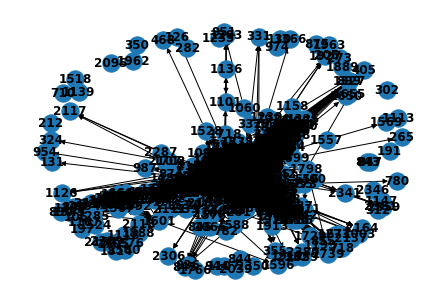

In [6]:
nx.draw(G, with_labels=True, font_weight='bold')